### FFT with rotating plate

The setup was conducted as follows:


1.The laser with wavelength $\lambda$ = 660 nm was calibrated to hit the polarimeter at the end of the setup centrally.


2.A train consisting of linear polarizer LP2 (Pol.), $\frac{\lambda}{2}$-WP 600 - 2700 nm and
$\frac{\lambda}{4}$-WP 690 - 1200 nm was assembled and placed into the laser beam.


3.By rotating the WPs of the train horizontally polarized light was set.

The angles of the optical elements in the train in the order set were $\Theta_{1}=49^{\circ}$
, $\Theta_{2}=227^{\circ}$ and $\Theta_{3}=???^{\circ}$

, because the last plate holder had no markings.

The parameters of the horizontally polarized light were: S1=1.000 ; S2=-0.002 ; S3=-0.004 ; DOP=103.9 % and power=-19.61 dBm

Annotation: The angle of LP2 (Pol.) in the train could have been set that maximum intensity is transmitted, but wasn't.


4.In order to find the angle $\alpha$
of the x-axis following procedure was used. Another linear polarizer LP3, which is here also referred to as P1, was inserted after the train and rotated until maximum intensity was measured by the polarimeter.This was the case for $\alpha_{1}=131^{\circ}$

The measured parameters were:

S1=0.999 ; S2=0.001 ; S3=0.041 ; DOP=103.7 % and power=-21.3 dBm


5.Another linear polarizer LP1, which is here also referred as P2, was inserted behind P1 just in front of the polarimeter and rotated until maximum intensity was measured by the polarimeter.This was the case for $\alpha_{2}=336^{\circ}$

The measured parameters were:

S1=1.000 ; S2=0.002 ; S3=0.002 ; DOP=103.7 % and power=-21.95 dBm

Now the angle of P2 is set to transmit horizontally polarized light most effectively and therefore this angle is assigned to the x-axis. Accordingly, in relation to the x-axis P2 is now set at $\alpha$=0.
This position is not changed during the measurement


6.All components are removed, except the train, and horizontally polarized light intended for measurement is set.

S1=0.999 ; S2=0.003 ; S3=0.020 ; DOP=103.6 % and power=-19.42 dBm


7.Behind the train we insert the $\frac{\lambda}{4}$
-WP 600 - 2700 nm in the rotating wheel and behind the wheel we insert LP1 as P2 at angle $\alpha$=0


8.The wheel is rotated from 0 to 2 𝜋
and 361 equally distanced data points are recorded

### Read in data for setup like in paper

In [461]:
import numpy as np
import matplotlib.pyplot as plt

from sympy import Symbol, cos, sin, pi, sqrt, symbols
from sympy.matrices import *
from sympy.utilities.lambdify import lambdify
from sympy.interactive.printing import init_printing
from sympy.interactive import printing
printing.init_printing(use_latex=True)

from scipy.optimize import curve_fit, minimize
from scipy import fftpack
import os
from os.path import join, getsize

directories=[]

# Some names for the data files to know which polarization
# 20190515[0]horizontal polarization
# 20190515[1]vertical polarization
# 20190516[0]diagonal polarization
# 20190520[0]antidiagonal polarization
# 20190521[0]left-circular polarization
# 20190521[1]right-circular polarization

for root, dirs, files in os.walk('20190521/'):
    if files != []:
        a=str(root)+str('/')+str(files[0])
        directories.append(a)

# Only horizontally polarized light
directories=directories[2:3]
print(directories)
data=[]
measurement_point_all=[]
angle_all=[]
s1_all=[]
s2_all=[]
s3_all=[]
dop_all=[]
power_all=[]

for i in directories:
    f=open(i)
    lines=f.readlines()
    for i in range(26):
        lines.pop(0)
    measurement_point=[]
    angle=[]
    s1=[]
    s2=[]
    s3=[]
    dop=[]
    power=[]
    for line in lines:
        measurement_point.append( line.strip().split('\t')[0] )
        angle.append( line.strip().split('\t')[1] )
        s1.append( line.strip().split('\t')[2] )
        s2.append( line.strip().split('\t')[3] )
        s3.append( line.strip().split('\t')[4] )
        dop.append( line.strip().split('\t')[5] )
        power.append( line.strip().split('\t')[6] )
    measurement_point_all.append(measurement_point)
    angle_all.append(angle)
    s1_all.append(s1)
    s2_all.append(s2)
    s3_all.append(s3)
    dop_all.append(dop)
    power_all.append(power)
measurement_point=np.array(measurement_point_all).astype(np.float)  
angle=np.array(angle_all).astype(np.float)
s1=np.array(s1_all).astype(np.float) 
s2=np.array(s2_all).astype(np.float)
s3=np.array(s3_all).astype(np.float) 
dop=np.array(dop_all).astype(np.float)
power=np.array(power_all).astype(np.float)

['20190521/103527_polarimeter_vs_wheel/103527_polarimeter_vs_wheel.dat']


Text(0.5, 1.0, 'Measurement for $\\frac{1}{2}$ WP #40')

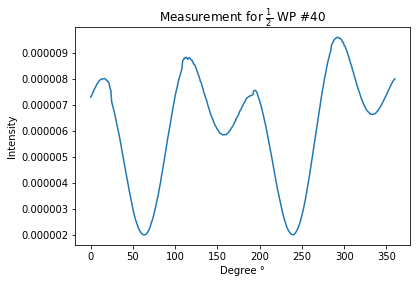

In [462]:
plt.figure()
plt.plot(angle[0], power[0])
plt.ylabel('Intensity')
plt.xlabel('Degree °')
plt.title(r'Measurement for $\frac{1}{2}$ WP #40')

### Calculate discrete Fourier series coefficients like in paper
For an uneven number of data points like in our case with N = 2L = 361 we can calculate the discrete Fourier series coefficients according to
$$C_{\omega, k}=\frac{2}{N} \frac{1}{1+\delta_{k0}} \sum_{i=1}^N I_{T_{i}} cos \omega_{k} \beta_{i}$$
$$S_{\omega, k}=\frac{2}{N} \frac{1}{1+\delta_{k0}} \sum_{i=1}^N I_{T_{i}} sin \omega_{k} \beta_{i}$$
with the discrete angular velocities
$$\omega_{k} = \frac{2\pi}{N} \frac{k}{\Delta \beta}$$ the angular positions $$\beta_{i}=(i-1)\Delta \beta$$ and $\Delta \beta$ being the difference in the angle for two neighboring data points.

We need to consider that due to the dependance of the discrete angular velocities on the step size, it can happen that the 2 $\omega$ and 4$\omega$ signals, which correspond to circular and linear polarizations, are not exactly included in our calculations. Therefore, we look for the discrete angular frequencies, which are closest to the requirements.

### Starting Parameters
S1=0.999
S2=-0.021
S3=-0.003
DOP: 103.6%
Power: -22.24 dBm

In [463]:
# Calculate discrete Fourier coefficients for an uneven number of data points N=2L+1
names=['H-light', 'L-light', 'E-light']
#%%
intensity=power[0]

L=180
N=2*L+1
index=np.linspace(0,2,361)


omega_k=[]
# Define step size
delta_beta=(index[1]-index[0])*2*np.pi
for i in np.arange(L):
    omega_k.append(2*np.pi*i/(N*delta_beta))
omega_k=np.array(omega_k)
# Calculate Fourier series coefficients
C_omega_k=[]
S_omega_k=[]
#print(len(index))
#print(omega_k)
# Sum in definition of C_omega_k with cos terms

def sum_cos(x):
    ''' Calculate formula from above with variable x=omega_{k}'''
    sum_cos=0
    j=0
    for i in index:
        sum_cos=sum_cos+ intensity[j]*np.cos(x*i*np.pi)
        j+=1
    return sum_cos
a=sum_cos(omega_k)

# Sum in definition of S_omega_k with sin terms
def sum_sin(x):
    '''Same with sin'''
    sum_sin=0
    j=0
    for i in index:
        sum_sin+= intensity[j]*np.sin(x*i*np.pi)
        j+=1
    return sum_sin

#print(sum_sin(omega_k))
def fourier_coefficients(x):
    '''Calculate complete Fourier coefficients'''
    C_omega_k=(2/N)* sum_cos(x)
    S_omega_k=(2/N)* sum_sin(x)
    return C_omega_k, S_omega_k


# Loop to get all Fourier coefficients
Cs=[]
indices=[]
Ss=[]
# Calculate only first 11 Fourier coefficients

# Find indices, where omega_k is closest to desired integer values

for i in np.arange(11):
    indices.append(np.where(  np.absolute(omega_k-i)==np.amin(np.absolute(omega_k-i)) )[0][0] )

for i in np.arange(11):
    Cs.append(fourier_coefficients(omega_k)[0][indices[i]])
    Ss.append(fourier_coefficients(omega_k)[1][indices[i]])
Cs[0]=Cs[0]*0.5
#Calculating Fourier coefficients, which correspond to omega_k=2, 4
# Same method as above, did it just to check if the method is right
# Find index of entry of omega_k, which is closest to omega_k = 0,2 or 4
index_0,=np.where( omega_k==np.amin(omega_k) )
index_2,=np.where(  np.absolute(omega_k-2)==np.amin(np.absolute(omega_k-2)) )
index_4,=np.where(  np.absolute(omega_k-4)==np.amin(np.absolute(omega_k-4)) )


#print('Cs=', Cs)
print(omega_k)
# Calculate Fourier coefficients for omega_k = 2,4
# Factor 0.5 for omega_k=0 to account for special case of fourier series coefficient formula
C0=fourier_coefficients(omega_k)[0][index_0[0]]*0.5
C2=fourier_coefficients(omega_k)[0][index_2[0]]
C4=fourier_coefficients(omega_k)[0][index_4[0]]
S2=fourier_coefficients(omega_k)[1][index_2[0]]
S4=fourier_coefficients(omega_k)[1][index_4[0]]


[ 0.          0.49861496  0.99722992  1.49584488  1.99445983  2.49307479
  2.99168975  3.49030471  3.98891967  4.48753463  4.98614958  5.48476454
  5.9833795   6.48199446  6.98060942  7.47922438  7.97783934  8.47645429
  8.97506925  9.47368421  9.97229917 10.47091413 10.96952909 11.46814404
 11.966759   12.46537396 12.96398892 13.46260388 13.96121884 14.4598338
 14.95844875 15.45706371 15.95567867 16.45429363 16.95290859 17.45152355
 17.9501385  18.44875346 18.94736842 19.44598338 19.94459834 20.4432133
 20.94182825 21.44044321 21.93905817 22.43767313 22.93628809 23.43490305
 23.93351801 24.43213296 24.93074792 25.42936288 25.92797784 26.4265928
 26.92520776 27.42382271 27.92243767 28.42105263 28.91966759 29.41828255
 29.91689751 30.41551247 30.91412742 31.41274238 31.91135734 32.4099723
 32.90858726 33.40720222 33.90581717 34.40443213 34.90304709 35.40166205
 35.90027701 36.39889197 36.89750693 37.39612188 37.89473684 38.3933518
 38.89196676 39.39058172 39.88919668 40.38781163 40.8864

We need to regard only the 0 $\omega$, 2$\omega$ and 4$\omega$ signals, as these are the only ones contributing to the resulting intensity. As expected for horizontally polarized light the coefficients C2 and S2, which correspond to circular polarized light, are suppressed

In [464]:
print("C0=", Cs[0])
print("C2=", Cs[2]) 
print("C4=", Cs[4])
print("S2=", Ss[2])
print("S4=", Ss[4])
print(np.linspace(0,360,7))

C0= 6.1784930294177704e-06
C2= 6.52469447960489e-07
C4= 6.583554175787486e-07
S2= -2.081753292968016e-06
S4= 1.9076431337136424e-06
[  0.  60. 120. 180. 240. 300. 360.]


### Calculate the other Stokes parameters
\begin{align}
M=\frac{2}{1-cos\delta}\left[C_{4}cos(2\alpha + 4\beta_{0}) + S_{4}sin(2\alpha + 4\beta_{0})\right]\\
|M|=\frac{2}{1-cos\delta} \left( C_{4}^2 + S_{4}^2  \right)^{\frac{1}{2}}\\
C=\frac{2}{1-cos\delta}\left[S_{4}cos(2\alpha + 4\beta_{0}) - C_{4}sin(2\alpha + 4\beta_{0})\right]\\
S=\frac{C_{2}}{sin\delta sin(2\alpha + 4\beta_{0})}=\frac{-S_{2}}{sin \delta cos(2\alpha + 4\beta_{0})}\\
|S|= \frac{  \left( C_{2}^2 + S_{2}^2\right)^{\frac{1}{2}}}{  sin^2 \delta}\\
I=C_{0} - \frac{1+cos \delta}{1-cos \delta} \left[  C_{4} cos(4 \alpha+ 4\beta_{0}) + S_{4} sin(4\alpha +4\beta_{0})     \right]
\end{align} 
In order to obtain the values of the parameters we need to measure the angles $\alpha$ and $\beta_{0}$, where $\alpha$ can be obtained while setting the system up and $\beta_{0}$ can be obtained by measuring either strongly circularly polarized light or strongly linearly polarized light and using the relations above.

For strongly linearly polarized light with C=S=0 we get
\begin{align}
tan(4\beta_{0} + 2\alpha)=\frac{S_{4}}{C_{4}}
\end{align}



We also need the retardance of the half-wave-plate. Here the theoretical retardance was used. There is also an estimate of the true retardance from another measurement, which is around $\delta$=$86-88^\circ$, but the error on that is yet unknown, so it is not used for now.

In [465]:
# Define retardance and angles
delta=np.pi/2
alpha=0
# Formula for linearly polarized light
#beta_0=(np.arctan(Ss[4]/Cs[4])-2*alpha)/4


if Ss[4]>0:
    print('AAa')
    beta_0=(np.arctan2(Ss[4],Cs[4])-2*alpha)/4
else:
    print('bbb')
    beta_0=(np.arctan2(Ss[4],Cs[4])+2*np.pi-2*alpha)/4


#beta_0=0.12812142407193355
#beta_0=((np.arctan(Ss[4]/Cs[4])-2*alpha)/4)
#beta_0=0.5209602662591997 #from 20190522[0] horizontal polarization
beta_0=0.5209602662591997

AAa


For $\beta_{0}$ from the formula for horizontally polarized light we get

In [466]:
display('beta_{0}', beta_0)
print(beta_0*180/np.pi)
print('Ss4/Cs4', Ss[4]/Cs[4])

'beta_{0}'

29.848824550663764
Ss4/Cs4 2.897588571123836


In [467]:
modulus_S=sqrt( Cs[2]**2 + Ss[2]**2  )/(np.sin(delta)**2)
modulus_M=sqrt( Cs[4]**2 + Ss[4]**2  )*2/(1-cos(delta))

print('|S|=', modulus_S)
print('|M|=', modulus_M)

# Calculate Stokes parameters from angles




# Calculate Stokes parameters from angles and Fourier coefficients
M=(2/(1-np.cos(delta)))*( Cs[4]*np.cos(2*alpha+4*beta_0) + Ss[4]*np.sin(2*alpha+4*beta_0)  )
C=(2/(1-np.cos(delta)))*( Ss[4]*np.cos(2*alpha+4*beta_0) - Cs[4]*np.sin(2*alpha+4*beta_0)  )
# Calculate S from Cs[2] and Ss[2] each to check on plausibility (see Formula)
S_first=Cs[2]/(np.sin(delta)*np.sin(2*alpha+4*beta_0))
S_second=-Ss[2]/(np.sin(delta)*np.cos(2*alpha+4*beta_0))
I=Cs[0]-((1+np.cos(delta))/(1-np.cos(delta)))*(Cs[4]*np.cos(4*alpha + 4*beta_0)+Ss[4]*np.sin(4*alpha + 4*beta_0))
L=np.sqrt(Cs[4]**2 +Ss[4]**2)/sin(delta/2)**2
L_other=sqrt(M**2 + C**2)
# Modulation ratio
# Corresponds to expectations for vertically polarized light
eta=M*(1-np.cos(delta))/(2*I + M*np.cos(2*alpha*(1+np.cos(delta))))

|S|= 2.18160792841084e-6
|M|= 4.03610415200604e-6


### Comparison computed Stokes parameters and measured Stokes parameters

$$\vec{S}_{Meas.}=\left(\begin{array}{c} 1 \\ 0.999 \\ 0.003 \\ 0.020 \end{array}\right)$$

We see that the S values have different signs, which could be due to weak 2 $\omega$ signals. The other values correspond to the measured values.

The magnitude of S can always be computed without knowing the angles $\alpha$ and $\beta$

In [468]:
print("C0=", Cs[0])
print("C2=", Cs[2]) 
print("C4=", Cs[4])
print("S2=", Ss[2])
print("S4=", Ss[4])
print('I=', I)
print('M/I=', (M/I) )
print('C/I=', (C/I)   )
print('S from C_{2}/I=', S_first/I)
print('S from -S_{2}/I=', S_second/I)
print('L/I',L/I)
print('L_other/I', L_other/I)

print('|S|=', modulus_S)
print('|S|/I with sign from S_{2}=', (modulus_S/I)*np.sign(S_second) )
print('|S|/I with sign from C_{2}=', (modulus_S/I)*np.sign(S_first) )

print('(L/I)**2 + (|S|/I)**2=',(L/I)**2 + (modulus_S/I)**2)

print('|M|', modulus_M)
print('|M|/I', modulus_M/I)

C0= 6.1784930294177704e-06
C2= 6.52469447960489e-07
C4= 6.583554175787486e-07
S2= -2.081753292968016e-06
S4= 1.9076431337136424e-06
I= 4.839593218385003e-06
M/I= 0.5533108881740129
C/I= -0.6239894849338647
S from C_{2}/I= 0.15474138864135603
S from -S_{2}/I= -0.8763695979046351
L/I 0.833975908692778
L_other/I 0.833975908692778
|S|= 2.18160792841084e-6
|S|/I with sign from S_{2}= -0.450783326194274
|S|/I with sign from C_{2}= 0.450783326194274
(L/I)**2 + (|S|/I)**2= 0.898721423454718
|M| 4.03610415200604e-6
|M|/I 0.833975908692778


For horizontally polarized light we can also calculate vertical polarization without knowing the angles $\alpha$ and $\beta$
$$|M|=\frac{2}{1-cos\delta} \left( C_{4}^2 + S_{4}^2  \right)^{\frac{1}{2}}$$

These values are also in agreement with the measurement

Absolute values for completeness

In [469]:
print('M=', M)
print('C=', C)
print('S_first=', S_first)
print('S_second=', S_second)
print('I=', I)
print('Modulation ratio eta=', eta)

M= 2.677799622065535e-06
C= -3.019855279629483e-06
S_first= 7.488853750721847e-07
S_second= -4.2412723628180634e-06
I= 4.839593218385003e-06
Modulation ratio eta= 0.2167032971726017


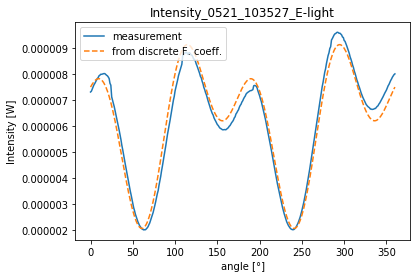

In [470]:
z=0
plt.plot(angle[z], power[z], label='measurement')

def I_T(x):
    return Cs[0]+Cs[2]*np.cos(2*x*np.pi/180)+Cs[4]*np.cos(4*x*np.pi/180)+Ss[2]*np.sin(2*x*np.pi/180)+Ss[4]*np.sin(4*x*np.pi/180)
    
plt.plot(angle[z], I_T(np.array(angle[z])), '--', label='from discrete F. coeff.' )
plt.xlabel('angle [°]')
plt.ylabel('Intensity [W]')
plt.legend()
plt.title('Intensity_0521_103527_E-light')
plt.savefig('Intensity_0521_10327_E-light.png', fmt='png')

### Modulation ratio

As an additional test we can look at the modulation ratio, which depends on some of the calculated parameters, to check on the plausibility of the result.

\begin{align} \eta = \frac{I_{max} - I_{min}}{I_{max} + I_{min}} = \frac{M(1-cos\delta)}{2I + Mcos2\alpha(1+ cos\delta)} \end{align}


In [471]:
eta_intensity=(np.amax(intensity)-np.amin(intensity))/(np.amax(intensity)+np.amin(intensity))

print('eta from intensity', eta_intensity)
print('eta from parameters', eta)

eta from intensity 0.6539118409209199
eta from parameters 0.2167032971726017


Modulation ratios from intensity and from parameters seem to agree with each other

### Plotting the coefficients

We expect strong 0 and 4 $\omega $ signals for horizontally polarized light, which is fulfilled in this case.

Text(0.5, 0.98, 'Fourier series coefficients')

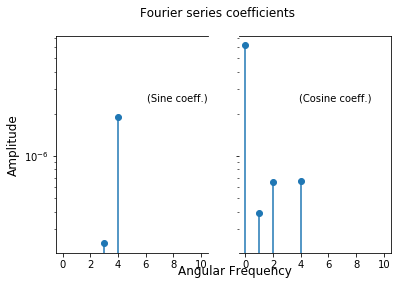

In [472]:
# Produce plots like in paper
#%%
t = np.arange(11)


fig, axs = plt.subplots(1, 2, sharey=True)
# Remove horizontal space between axes

fig.subplots_adjust(wspace=0.2)

# Plot each graph, and manually set the y tick values
axs[0].stem(t, Ss)
axs[0].set_yscale('log')
axs[0].text(0.8,-0.1, 'Angular Frequency', fontsize=12, transform=axs[0].transAxes)
axs[0].text(0.6,0.7, '(Sine coeff.)', fontsize=10, transform=axs[0].transAxes)

axs[0].set_ylabel('Amplitude', fontsize=12)
axs[0].set_xticks(ticks=np.arange(0,11,2))
axs[0].set_xticks(ticks=np.arange(0,11,2))
axs[0].spines['right'].set_visible(False)

axs[1].stem(t, Cs)
axs[1].text(0.4,0.7, '(Cosine coeff.)', fontsize=10, transform=axs[1].transAxes)
#axs[1].set_yticks([])
axs[1].set_xticks(ticks=np.arange(0,11,2))
axs[1].spines['left'].set_visible(False)
plt.suptitle('Fourier series coefficients')

### Calculate Stokes Parameter using FFT on intensity

Do a FFT on the intensity to see if the sought-after frequencies are present

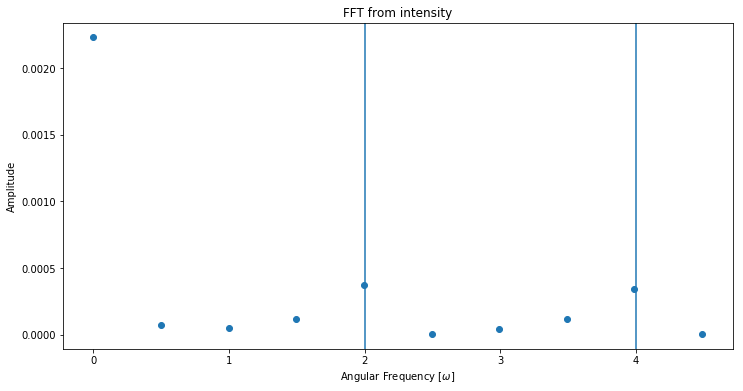

In [473]:



# Number of sample points N from above
# Sample spacing i times omega

A=fftpack.rfft(intensity)




plt.figure(figsize = (12,6))
plt.title('FFT from intensity')
# Plot first 10 omegas
plt.plot(omega_k[0:10], np.abs(A)[0:10], 'o')
plt.xlabel(r'Angular Frequency [$\omega$]')
plt.ylabel('Amplitude')
plt.axvline(x=2  )
plt.axvline(x= 4  )

# Use the same formulas again

In [474]:
print(np.arctan2(-1,1)*180/np.pi )

-45.0


In [475]:
print(np.linspace(0,359,180))

[  0.           2.00558659   4.01117318   6.01675978   8.02234637
  10.02793296  12.03351955  14.03910615  16.04469274  18.05027933
  20.05586592  22.06145251  24.06703911  26.0726257   28.07821229
  30.08379888  32.08938547  34.09497207  36.10055866  38.10614525
  40.11173184  42.11731844  44.12290503  46.12849162  48.13407821
  50.1396648   52.1452514   54.15083799  56.15642458  58.16201117
  60.16759777  62.17318436  64.17877095  66.18435754  68.18994413
  70.19553073  72.20111732  74.20670391  76.2122905   78.21787709
  80.22346369  82.22905028  84.23463687  86.24022346  88.24581006
  90.25139665  92.25698324  94.26256983  96.26815642  98.27374302
 100.27932961 102.2849162  104.29050279 106.29608939 108.30167598
 110.30726257 112.31284916 114.31843575 116.32402235 118.32960894
 120.33519553 122.34078212 124.34636872 126.35195531 128.3575419
 130.36312849 132.36871508 134.37430168 136.37988827 138.38547486
 140.39106145 142.39664804 144.40223464 146.40782123 148.41340782
 150.418994